# Basics audio loading and playback with Python

 * By: **Fernando Garcia** (fergarciadlc)
 * Date: February 2nd 2021
 * Description: Sample notebook to load and playback audio files and arrays
 
For running this notebook make sure to have all dependencies installed with:
    
    (venv)$ pip install -r requirements-fernando.txt

## Contents

 * [PyAudio](#PyAudio)
  * [Blocking Mode Audio I/O](#Example:-Blocking-Mode-Audio-I/O)
  * [Callback Mode Audio I/O](#Example:-Callback-Mode-Audio-I/O)
 * [Audio manipulation with Numpy-Scipy-SoundDevice](#Audio-manipulation-with-Numpy-Scipy-SoundDevice)
  * [How to play a NumPy array with audio directly to a speaker](#Example)
 * [Other Alternatives](#Other-alternatives)
  * [simpleaudio](#simpleaudio)
  * [winsound](#winsound)
  * [python sounddevice](#python-sounddevice)
  * [pydub](#pydub)

# PyAudio
https://people.csail.mit.edu/hubert/pyaudio/docs/

## Example: Blocking Mode Audio I/O
PyAudio provides Python bindings for PortAudio, the cross-platform audio I/O library. With PyAudio, you can easily use Python to play and record audio on a variety of platforms. PyAudio is inspired by:

 * pyPortAudio/fastaudio: Python bindings for PortAudio v18 API.
 * tkSnack: cross-platform sound toolkit for Tcl/Tk and Python.
 
CLI Usage with sys

In [1]:
"""PyAudio Example: Play a wave file."""

import pyaudio
import wave
import sys

CHUNK = 1024

# if len(sys.argv) < 2:
#     print("Plays a wave file.\n\nUsage: %s filename.wav" % sys.argv[0])
#     sys.exit(-1)

# wf = wave.open(sys.argv[1], 'rb')
wf = wave.open("audiodata/e2.wav", 'rb')

# instantiate PyAudio (1)
p = pyaudio.PyAudio()

# open stream (2)
stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                channels=wf.getnchannels(),
                rate=wf.getframerate(),
                output=True)

# read data
data = wf.readframes(CHUNK)

# play stream (3)
while len(data) > 0:
    stream.write(data)
    data = wf.readframes(CHUNK)

# stop stream (4)
stream.stop_stream()
stream.close()

# close PyAudio (5)
p.terminate()

To use PyAudio, first instantiate PyAudio using **`pyaudio.PyAudio()`** (1), which sets up the portaudio system.

To record or play audio, open a stream on the desired device with the desired audio parameters using **`pyaudio.PyAudio.open()`** (2). This sets up a **`pyaudio.Stream`** to play or record audio.

Play audio by writing audio data to the stream using **`pyaudio.Stream.write()`**, or read audio data from the stream using **`pyaudio.Stream.read()`**. (3)

Note that in "blocking mode", each **`pyaudio.Stream.write()`** or **`pyaudio.Stream.read()`** blocks until all the given/requested frames have been played/recorded. Alternatively, to generate audio data on the fly or immediately process recorded audio data, use the "callback mode" outlined below.

Use **`pyaudio.Stream.stop_stream()`** to pause playing/recording, and **`pyaudio.Stream.close()`** to terminate the stream. (4)

Finally, terminate the portaudio session using **`pyaudio.PyAudio.terminate()`** (5)

# Example: Callback Mode Audio I/O
In callback mode, PyAudio will call a specified callback function (2) whenever it needs new audio data (to play) and/or when there is new (recorded) audio data available. Note that PyAudio calls the callback function in a separate thread. The function has the following signature `callback(<input_data>, <frame_count>, <time_info>, <status_flag>)` and must return a tuple containing frame_count frames of audio data and a flag signifying whether there are more frames to play/record.

Start processing the audio stream using **`pyaudio.Stream.start_stream()`** (4), which will call the callback function repeatedly until that function returns **`pyaudio.paComplete`**.

To keep the stream active, the main thread must not terminate, e.g., by sleeping (5).

In [2]:
"""PyAudio Example: Play a wave file (callback version)."""

import pyaudio
import wave
import time
import sys

# if len(sys.argv) < 2:
#     print("Plays a wave file.\n\nUsage: %s filename.wav" % sys.argv[0])
#     sys.exit(-1)

# wf = wave.open(sys.argv[1], 'rb')
wf = wave.open("audiodata/e2.wav",'rb')

# instantiate PyAudio (1)
p = pyaudio.PyAudio()

# define callback (2)
def callback(in_data, frame_count, time_info, status):
    data = wf.readframes(frame_count)
    return (data, pyaudio.paContinue)

# open stream using callback (3)
stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                channels=wf.getnchannels(),
                rate=wf.getframerate(),
                output=True,
                stream_callback=callback)

# start the stream (4)
stream.start_stream()

# wait for stream to finish (5)
while stream.is_active():
    time.sleep(0.1)

# stop stream (6)
stream.stop_stream()
stream.close()
wf.close()

# close PyAudio (7)
p.terminate()

# Audio manipulation with Numpy-Scipy-SoundDevice

In [3]:
from scipy.io import wavfile
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt

### wavfie.read Docstring

    Returns
    -------
    rate : int
        Sample rate of WAV file.
    data : numpy array
        Data read from WAV file. Data-type is determined from the file;
        see Notes.  Data is 1-D for 1-channel WAV, or 2-D of shape
        (Nsamples, Nchannels) otherwise. If a file-like input without a
        C-like file descriptor (e.g., :class:`python:io.BytesIO`) is
        passed, this will not be writeable.

    Notes
    -----
    Common data types: [1]_

    =====================  ===========  ===========  =============
         WAV format            Min          Max       NumPy dtype
    =====================  ===========  ===========  =============
    32-bit floating-point  -1.0         +1.0         float32
    32-bit integer PCM     -2147483648  +2147483647  int32
    24-bit integer PCM     -2147483648  +2147483392  int32
    16-bit integer PCM     -32768       +32767       int16
    8-bit integer PCM      0            255          uint8
    =====================  ===========  ===========  =============

In [4]:
fs, data = wavfile.read("audiodata/coronavirus.wav")

<ipython-input-4-d4e99bbbb700>:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data = wavfile.read("audiodata/coronavirus.wav")


In [5]:
fs

44100

In [6]:
type(data)

numpy.ndarray

In [7]:
# time axis
x = np.arange(0,len(data)) / fs

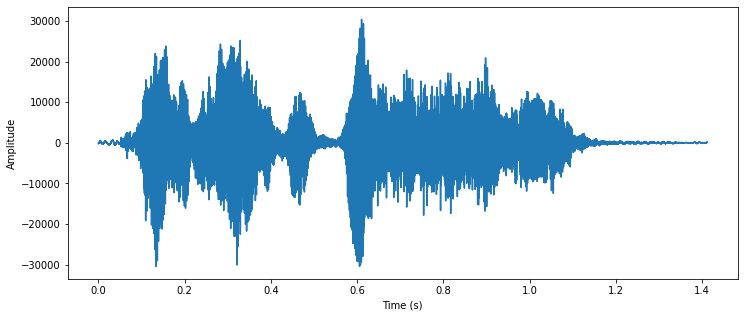

In [8]:
plt.figure(figsize=(12,5))
plt.plot(x, data)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()
sd.play(data, fs)

# Example
## How to play a NumPy array with audio directly to a speaker
https://gist.github.com/akey7/94ff0b4a4caf70b98f0135c1cd79aff3

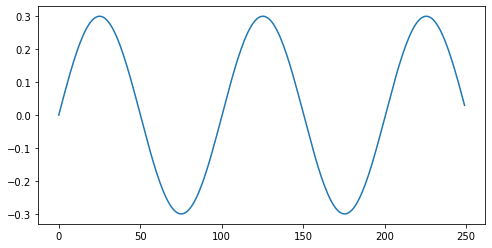

In [9]:

# Use the sounddevice module
# http://python-sounddevice.readthedocs.io/en/0.3.10/

import numpy as np
import sounddevice as sd
import time

# Samples per second
sps = 44100

# Frequency / pitch
freq_hz = 440.0

# Duration
duration_s = 1.2

# Attenuation so the sound is reasonable
atten = 0.3

# NumpPy magic to calculate the waveform
each_sample_number = np.arange(duration_s * sps)
waveform = np.sin(2 * np.pi * each_sample_number * freq_hz / sps)
waveform_quiet = waveform * atten

plt.figure(figsize=(8,4))
plt.plot(waveform_quiet[:250])
plt.show()

# Play the waveform out the speakers
sd.play(waveform_quiet, sps)
time.sleep(duration_s)
sd.stop()

# Other alternatives
https://realpython.com/playing-and-recording-sound-python/

## simpleaudio

    pip install --upgrade pip setuptools
    pip install simpleaudio


In [10]:
import time

In [11]:
import simpleaudio as sa

filename = 'audiodata/synth-gliss-a.wav'
wave_obj = sa.WaveObject.from_wave_file(filename)
play_obj = wave_obj.play()
time.sleep(0.5)
filename = 'audiodata/e2.wav'
wave_obj = sa.WaveObject.from_wave_file(filename)
play_obj = wave_obj.play()
# play_obj.wait_done()  # Wait until sound has finished playing

WAV files contain a sequence of bits representing the raw audio data, as well as headers with metadata in RIFF (Resource Interchange File Format) format.

For CD recordings, the industry standard is to store each audio sample (an individual audio datapoint relating to air pressure) as a 16-bit value, at 44100 samples per second.

To reduce file size, it may be sufficient to store some recordings (for example of human speech) at a lower sampling rate, such as 8000 samples per second, although this does mean that higher sound frequencies may not be as accurately represented.

A few of the libraries discussed in this tutorial play and record bytes objects, whereas others use NumPy arrays to store raw audio data.

Both correspond to a sequence of data points that can be played back at a specified sample rate in order to play a sound. For a bytes object, each sample is stored as a set of two 8-bit values, whereas in a NumPy array, each element can contain a 16-bit value corresponding to a single sample.

An important difference between these two data types is that bytes objects are immutable, whereas NumPy arrays are mutable, making the latter more suitable for generating sounds and for more complex signal processing.

simpleaudio allows you to play NumPy and Python arrays and bytes objects using simpleaudio.play_buffer()

In [12]:
frequency = 440  # Our played note will be 440 Hz
fs = 44100  # 44100 samples per second
seconds = 1  # Note duration of 1 second

# Generate array with seconds*sample_rate steps, ranging between 0 and seconds
t = np.linspace(0, seconds, seconds * fs, False)

# Generate a 440 Hz sine wave
note = np.sin(frequency * t * 2 * np.pi)

# Ensure that highest value is in 16-bit range
audio = note * (2**15 - 1) / np.max(np.abs(note))
# Convert to 16-bit data
audio = audio.astype(np.int16)

# Start playback
play_obj = sa.play_buffer(audio, 1, 2, fs)

# Wait for playback to finish before exiting
play_obj.wait_done()

## winsound

In [13]:
import winsound

filename = 'audiodata/e2.wav'
winsound.PlaySound(filename, winsound.SND_FILENAME)

In [14]:
winsound.Beep(1000, 100)  # Beep at 1000 Hz for 100 ms

## python sounddevice

In [15]:
import sounddevice as sd
import soundfile as sf

filename = 'audiodata/synth-gliss-a.wav'
# Extract data and sampling rate from file
data, fs = sf.read(filename, dtype='float32')  
sd.play(data, fs)
status = sd.wait()  # Wait until file is done playing

## pydub
8 bit sounds awful!!

In [16]:
from pydub import AudioSegment
from pydub.playback import play

sound = AudioSegment.from_wav('audiodata/coronavirus.wav')
play(sound)